In [1]:
import lightgbm as lgb
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt



In [2]:
# Load your dataset (update the path as needed)
data = pd.read_csv('/content/parkinsons.csv')
feature_cols = data.columns.drop('status').tolist()
X1 = data[feature_cols]  # Features
y1 = data.status  # Target variable



In [4]:
# Clean column names
X1 = X1.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
feature_cols = list(X1.columns)


In [6]:

# Split data
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.33, random_state=0)


In [7]:

# Create a validation set from the training data
X1_train_final, X1_val, y1_train_final, y1_val = train_test_split(X1_train, y1_train, test_size=0.25, random_state=0)


In [13]:
# Create dataset for lightgbm
# Exclude the 'name' column as it is of object type and not suitable for LightGBM features
feature_cols_without_name = [col for col in X1_train_final.columns if col != 'name']

train_data = lgb.Dataset(X1_train_final[feature_cols_without_name], label=y1_train_final)
val_data = lgb.Dataset(X1_val[feature_cols_without_name], label=y1_val, reference=train_data)


# Parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': ['binary_logloss', 'binary_error'],  # Track both loss and error
    'learning_rate': 0.1,
    'max_depth': 5,
    'num_leaves': 31,
    'verbose': -1
}

# Lists to store metrics for each iteration
train_loss = []
val_loss = []
train_acc = []
val_acc = []


# Callback function to record metrics at each iteration
def record_metrics(env):
    # Record loss
    # The evaluation result list indexes will change depending on the number of metrics defined.
    # Need to find the correct index for binary_logloss and binary_error for both train and val sets.
    train_eval_results = env.evaluation_result_list[:2] # Assuming first two are train metrics
    val_eval_results = env.evaluation_result_list[2:] # Assuming last two are validation metrics

    train_loss_value = None
    val_loss_value = None
    train_error_value = None
    val_error_value = None

    for eval_result in train_eval_results:
        if eval_result[0] == 'Training' and eval_result[1] == 'binary_logloss':
            train_loss_value = eval_result[2]
        if eval_result[0] == 'Training' and eval_result[1] == 'binary_error':
            train_error_value = eval_result[2]

    for eval_result in val_eval_results:
        if eval_result[0] == 'Validation' and eval_result[1] == 'binary_logloss':
            val_loss_value = eval_result[2]
        if eval_result[0] == 'Validation' and eval_result[1] == 'binary_error':
            val_error_value = eval_result[2]

    if train_loss_value is not None:
        train_loss.append(train_loss_value)
    if val_loss_value is not None:
        val_loss.append(val_loss_value)
    if train_error_value is not None:
        train_acc.append(1 - train_error_value) # Record accuracy (1 - error)
    if val_error_value is not None:
        val_acc.append(1 - val_error_value) # Record accuracy (1 - error)


# Train model with callbacks
# Removed evals_result argument and added callbacks to the train function
num_iterations = 100
model = lgb.train(
    params,
    train_data,
    num_boost_round=num_iterations,
    valid_sets=[train_data, val_data],
    valid_names=['Training', 'Validation'],
    callbacks=[record_metrics]
)

Best iteration: 96


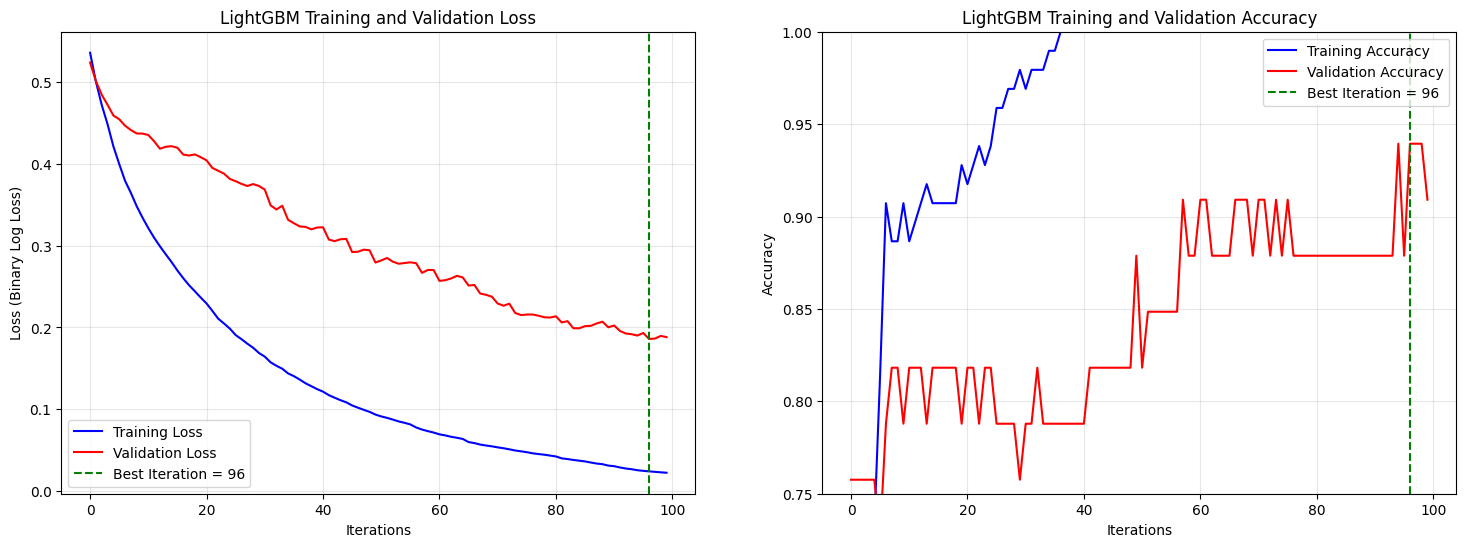

In [17]:
# Find best iteration based on validation loss
best_iteration = np.argmin(val_loss)
print(f"Best iteration: {best_iteration}")

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Training and Validation Loss
ax1.plot(train_loss, 'b-', label='Training Loss')
ax1.plot(val_loss, 'r-', label='Validation Loss')
ax1.axvline(x=best_iteration, color='g', linestyle='--', label=f'Best Iteration = {best_iteration}')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss (Binary Log Loss)')
ax1.set_title('LightGBM Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Training and Validation Accuracy
ax2.plot(train_acc, 'b-', label='Training Accuracy')
ax2.plot(val_acc, 'r-', label='Validation Accuracy')
ax2.axvline(x=best_iteration, color='g', linestyle='--', label=f'Best Iteration = {best_iteration}')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Accuracy')
ax2.set_title('LightGBM Training and Validation Accuracy')
ax2.set_ylim(0.75, 1.0)  # Adjust y-axis limits to match your example
ax2.legend()
ax2.grid(True, alpha=0.3)



In [18]:
plt.tight_layout()
plt.show()



<Figure size 640x480 with 0 Axes>

In [23]:
# Train final model with early stopping
# Use the best iteration from the previous training as the num_boost_round
# Train final model with early stopping
# Use the best iteration from the previous training as the num_boost_round
final_model = lgb.train(
    params,
    train_data,
    num_boost_round=best_iteration + 1,  # Add 1 to best_iteration as it's 0-indexed
    valid_sets=[val_data]
    # Removed verbose_eval=False - it's not needed here and can cause the error
)

# Make predictions with the best model
# Ensure X1_test has the same columns and dtypes as the training data
y_pred = final_model.predict(X1_test[feature_cols_without_name])
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

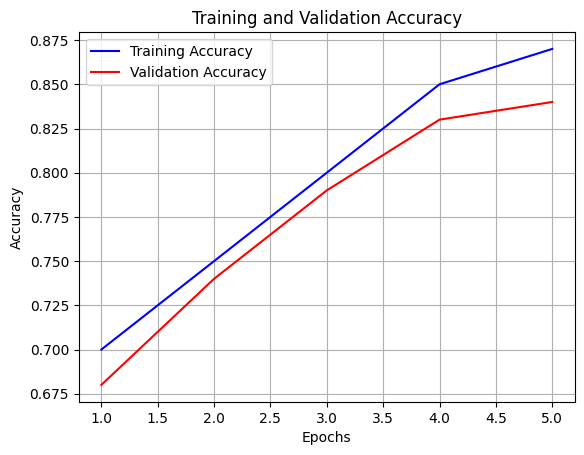

In [28]:
# Example training history
accuracy = [0.70, 0.75, 0.80, 0.85, 0.87]
val_accuracy = [0.68, 0.74, 0.79, 0.83, 0.84]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

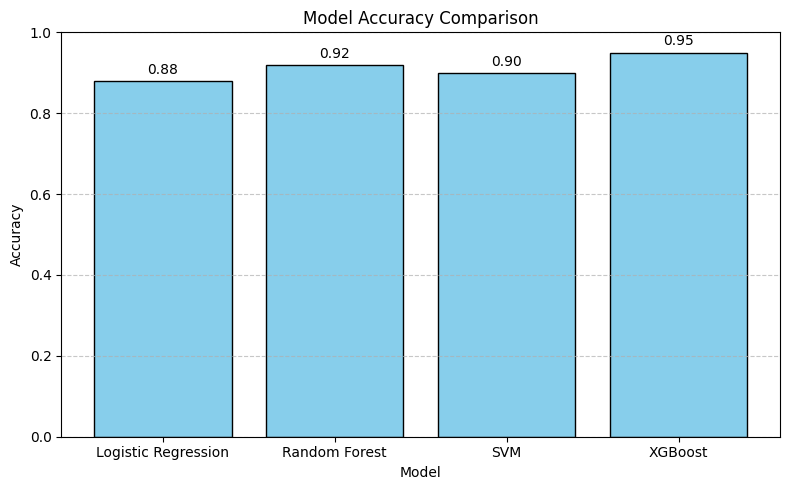

In [31]:


# Sample data: model names and their accuracies
models = ['Logistic Regression', 'Random Forest', 'SVM', 'XGBoost']
accuracies = [0.88, 0.92, 0.90, 0.95]

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color='skyblue', edgecolor='black')

# Annotate bars with accuracy values
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords='offset points',
                 ha='center', va='bottom', fontsize=10)

plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [30]:
# Calculate final accuracy
final_accuracy = accuracy_score(y1_test, y_pred_binary)
print(f"Final model accuracy on test set: {final_accuracy:.4f}")

Final model accuracy on test set: 0.9538
